In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("WikiVoteAnalysis") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12") \
    .getOrCreate()
from graphframes import GraphFrame
from pyspark.sql import functions as F
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from pyspark.sql import functions as F, types as T

# Read as raw text
raw = spark.read.text("/content/wiki-Vote.txt")

# Clean lines: strip, drop blanks & comments
lines = (raw
         .select(F.trim(F.col("value")).alias("line"))
         .filter((F.col("line") != "") & (~F.col("line").startswith("#"))))

# Split into two integers (src, dst)
parts = F.split(F.col("line"), r"\s+")
edges = (lines
         .select(parts.getItem(0).cast(T.IntegerType()).alias("src"),
                 parts.getItem(1).cast(T.IntegerType()).alias("dst"))
         .dropna()
         .dropDuplicates())

edges.show(5)

+---+----+
|src| dst|
+---+----+
|  6| 274|
|  6| 826|
|  7|  55|
| 11|1248|
| 17|1218|
+---+----+
only showing top 5 rows



In [4]:
pdf = edges.toPandas()
print(pdf.head())

   src   dst
0    6   274
1    6   826
2    7    55
3   11  1248
4   17  1218


In [5]:
csv_path = "/content/wiki-Vote.csv"
pdf.to_csv(csv_path, index=False)
print("Saved edges to:", csv_path)

Saved edges to: /content/wiki-Vote.csv


In [6]:
import pandas as pd
df = pd.read_csv("/content/wiki-Vote.csv")
df.head()

,src,dst
0,6,274
1,6,826
2,7,55
3,11,1248
4,17,1218


PART-B

In [7]:
#now that i have the df start processing using graphframes
from pyspark.sql import functions as F, types as T
from graphframes import GraphFrame

path = "/content/wiki-Vote.txt"

# 1) Read as raw lines
raw = spark.read.text(path)

# 2) Drop blanks and comment lines; normalize whitespace
lines = (raw
         .select(F.trim(F.col("value")).alias("line"))
         .filter((F.col("line") != "") & (~F.col("line").startswith("#"))))

# 3) Split on ANY whitespace and cast to ints/longs
parts = F.split(F.col("line"), r"\s+")
edges = (lines
         .select(parts.getItem(0).cast(T.LongType()).alias("src"),
                 parts.getItem(1).cast(T.LongType()).alias("dst"))
         .dropna()
         .dropDuplicates())

# 4) Build vertices and GraphFrame
vertices = edges.selectExpr("src as id").union(edges.selectExpr("dst as id")).distinct()
g = GraphFrame(vertices, edges)
edges.show(5, truncate=False)

print("Part B:\n")
print("Edges:", edges.count())
print("Nodes:", vertices.count())


+---+----+
|src|dst |
+---+----+
|3  |586 |
|25 |255 |
|25 |590 |
|7  |1193|
|8  |232 |
+---+----+
only showing top 5 rows

Part B:

Edges: 103689
Nodes: 7115


PART-C AND PART-D

In [8]:
spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

# ---------- WCC (Weakly Connected Components) ----------
wcc = g.connectedComponents().cache()

wcc_sizes = (wcc
    .groupBy("component")
    .count()
    .orderBy(F.desc("count")))

# largest WCC (by nodes)
largest_wcc_row    = wcc_sizes.first()
largest_wcc_id     = largest_wcc_row["component"]
largest_wcc_nodes  = largest_wcc_row["count"]

# vertices belonging to the largest WCC
largest_wcc_vertices = wcc.filter(F.col("component") == largest_wcc_id).select("id")

# edges fully inside the largest WCC
w_ids = wcc.select("id", "component")
edges_wcc = (g.edges
    .join(w_ids.withColumnRenamed("id","src"), "src")
    .withColumnRenamed("component","csrc")
    .join(w_ids.withColumnRenamed("id","dst"), "dst")
    .withColumnRenamed("component","cdst"))

largest_wcc_edges = edges_wcc.where(
    (F.col("csrc") == largest_wcc_id) & (F.col("cdst") == largest_wcc_id)
).count()

print(f"Largest WCC -> nodes={largest_wcc_nodes}, edges={largest_wcc_edges}")
# Ground truth: nodes=7066, edges=103663


# ---------- SCC (Strongly Connected Components) ----------
scc = g.stronglyConnectedComponents(maxIter=20).cache()

# sizes of SCCs (number of vertices per component), sorted DESC
scc_sizes = (scc
    .groupBy("component")
    .count()
    .orderBy(F.desc("count")))

# largest SCC (by nodes)
largest_scc_row    = scc_sizes.first()
largest_scc_id     = largest_scc_row["component"]
largest_scc_nodes  = largest_scc_row["count"]

# vertices belonging to the largest SCC
largest_scc_vertices = scc.filter(F.col("component") == largest_scc_id).select("id")

# edges fully inside the largest SCC
s_ids = scc.select("id", "component")
edges_scc = (g.edges
    .join(s_ids.withColumnRenamed("id","src"), "src")
    .withColumnRenamed("component","csrc")
    .join(s_ids.withColumnRenamed("id","dst"), "dst")
    .withColumnRenamed("component","cdst"))

largest_scc_edges = edges_scc.where(
    (F.col("csrc") == largest_scc_id) & (F.col("cdst") == largest_scc_id)
).count()

print(f"Largest SCC -> nodes={largest_scc_nodes}, edges={largest_scc_edges}")
# Ground truth: nodes=1300, edges=39456


# peek at the top components
print("\nTop WCCs by node count:")
wcc_sizes.show(5, truncate=False)

print("Top SCCs by node count:")
scc_sizes.show(5, truncate=False)

print("\nSample of vertices in the largest WCC:")
largest_wcc_vertices.limit(10).show(truncate=False)

print("Sample of vertices in the largest SCC:")
largest_scc_vertices.limit(10).show(truncate=False)

Largest WCC -> nodes=7066, edges=103663
Largest SCC -> nodes=1300, edges=39456

Top WCCs by node count:
+---------+-----+
|component|count|
+---------+-----+
|3        |7066 |
|8074     |3    |
|7031     |3    |
|7465     |3    |
|6089     |2    |
+---------+-----+
only showing top 5 rows

Top SCCs by node count:
+---------+-----+
|component|count|
+---------+-----+
|3        |1300 |
|2509     |1    |
|2453     |1    |
|2250     |1    |
|4894     |1    |
+---------+-----+
only showing top 5 rows


Sample of vertices in the largest WCC:
+----+
|id  |
+----+
|29  |
|3764|
|4894|
|26  |
|1697|
|1677|
|2214|
|7225|
|2509|
|2250|
+----+

Sample of vertices in the largest SCC:
+----+
|id  |
+----+
|667 |
|5384|
|5928|
|4992|
|6097|
|1596|
|2117|
|1732|
|2325|
|1550|
+----+



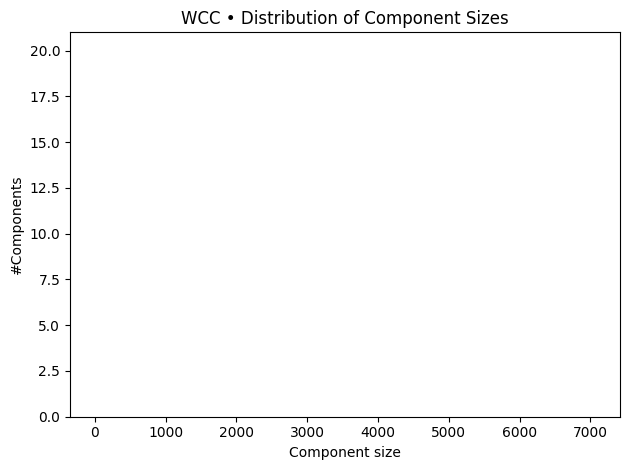

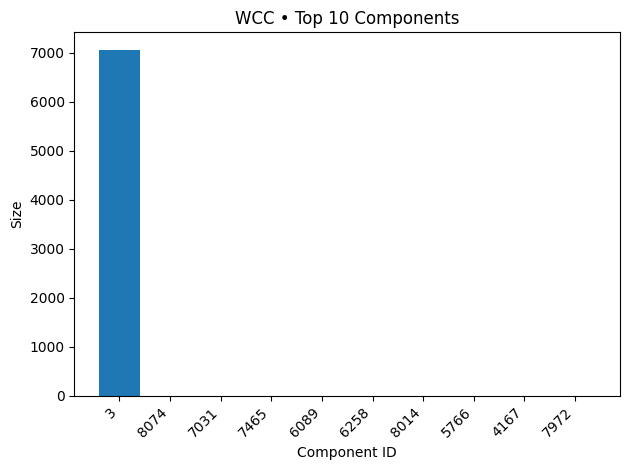

In [9]:
wcc_sizes_pd = (wcc_sizes
                .select(F.col("count").alias("size"))
                .groupBy("size").count()
                .orderBy("size")).toPandas()
plt.figure()
plt.bar(wcc_sizes_pd["size"], wcc_sizes_pd["count"])
plt.xlabel("Component size")
plt.ylabel("#Components")
plt.title("WCC • Distribution of Component Sizes")
plt.tight_layout()
plt.savefig("viz_wcc_component_size_hist.png", dpi=150)
plt.show()

wcc_top_pd = wcc_sizes.limit(10).toPandas()
plt.figure()
plt.bar(wcc_top_pd["component"].astype(str), wcc_top_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Component ID")
plt.ylabel("Size")
plt.title("WCC • Top 10 Components")
plt.tight_layout()
plt.savefig("viz_wcc_top_components.png", dpi=150)
plt.show()

This visualization shows the weakly connected component (WCC) structure of the wiki-Vote graph. The top plot (“Distribution of Component Sizes”) makes it clear that almost all components are very small (isolated nodes or tiny clusters), while one giant component dominates at around 7,000 nodes. The bottom plot (“Top 10 Components”) confirms this: the largest WCC has ~7,066 nodes, whereas all other components are negligible in size (essentially near zero compared to the giant). In short, the graph is overwhelmingly connected through one giant cluster, with only a scattering of tiny disconnected pieces.

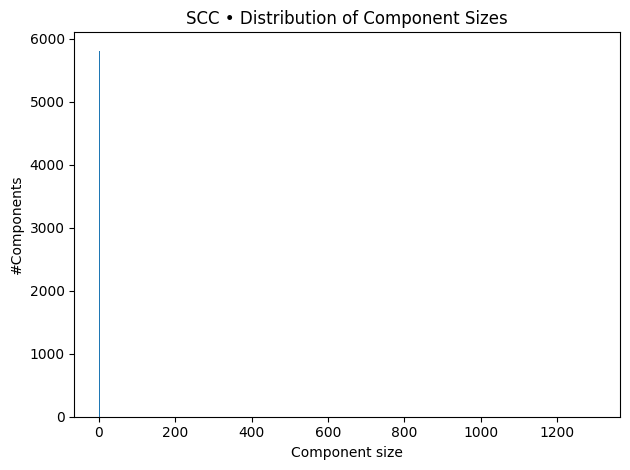

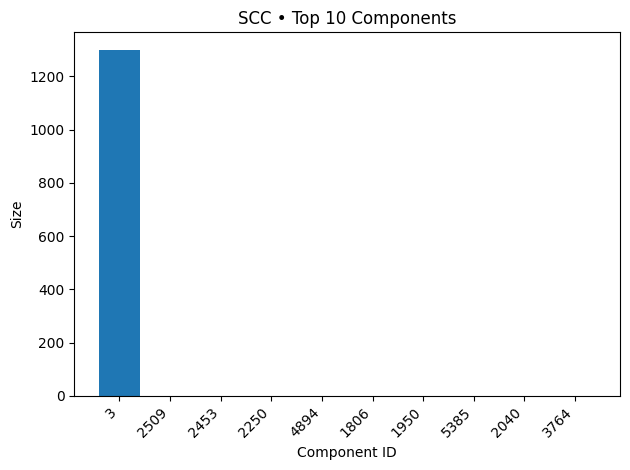

In [10]:
scc_sizes_pd = (scc_sizes
                .select(F.col("count").alias("size"))
                .groupBy("size").count()
                .orderBy("size")).toPandas()
plt.figure()
plt.bar(scc_sizes_pd["size"], scc_sizes_pd["count"])
plt.xlabel("Component size")
plt.ylabel("#Components")
plt.title("SCC • Distribution of Component Sizes")
plt.tight_layout()
plt.savefig("viz_scc_component_size_hist.png", dpi=150)
plt.show()

scc_top_pd = scc_sizes.limit(10).toPandas()
plt.figure()
plt.bar(scc_top_pd["component"].astype(str), scc_top_pd["count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Component ID")
plt.ylabel("Size")
plt.title("SCC • Top 10 Components")
plt.tight_layout()
plt.savefig("viz_scc_top_components.png", dpi=150)
plt.show()

This is the SCC (strongly connected components) picture of wiki-Vote. The top chart shows an extreme spike at very small sizes (mostly 1), meaning most nodes aren’t in mutual-reach cycles—links are largely one-way. The bottom chart (Top-10 SCCs) shows a single dominant SCC ≈ 1.3k nodes and the rest are tiny, confirming a classic “bow-tie”: a tightly interlinked core of reciprocally connected users surrounded by a huge periphery that can reach the core (or be reached by it) but not loop back. In short: directionality shatters the graph—one big strongly connected core, and thousands of singleton/small SCCs.

PART-E

In [11]:
edges_undirected = (
    g.edges
    .where(F.col("src") != F.col("dst"))
    .withColumn("a", F.least("src","dst"))
    .withColumn("b", F.greatest("src","dst"))
    .select(F.col("a").alias("src"), F.col("b").alias("dst"))
    .distinct()
)
g_undirected = GraphFrame(g.vertices.select("id").distinct(), edges_undirected)

deg = g_undirected.degrees.select("id","degree").cache()
tc  = g_undirected.triangleCount().select("id","count").cache()

all_v = g.vertices.select("id").distinct()

tc_deg_all = (all_v
              .join(deg, "id", "left")
              .join(tc,  "id", "left")
              .fillna({"degree": 0, "count": 0})
              .withColumn(
                  "clust",
                  F.when(F.col("degree") >= 2,
                         (2.0 * F.col("count")) / (F.col("degree") * (F.col("degree") - 1)))
                   .otherwise(F.lit(0.0))
              ))

avg_clustering = tc_deg_all.select(F.avg("clust")).first()[0]

total_triangles = int(tc_deg_all.agg(F.sum("count")).first()[0] // 3)

wedges = (tc_deg_all
          .withColumn("w", (F.col("degree") * (F.col("degree") - 1)) / 2.0)
          .agg(F.sum("w")).first()[0])

closure_ratio_T_over_tau = float(total_triangles / wedges) if wedges and wedges > 0 else None
transitivity_3T_over_tau  = float((3.0 * total_triangles) / wedges) if wedges and wedges > 0 else None

print("Average clustering coefficient (all 7,115 nodes, undirected simple):", avg_clustering)
print("Triangles (undirected simple):", total_triangles)
print("Fraction of closed triangles T/τ (closure ratio):", closure_ratio_T_over_tau)
print("Transitivity 3T/τ (for reference):", transitivity_3T_over_tau)

Average clustering coefficient (all 7,115 nodes, undirected simple): 0.14089784589308701
Triangles (undirected simple): 608389
Fraction of closed triangles T/τ (closure ratio): 0.04182638299744665
Transitivity 3T/τ (for reference): 0.12547914899233995


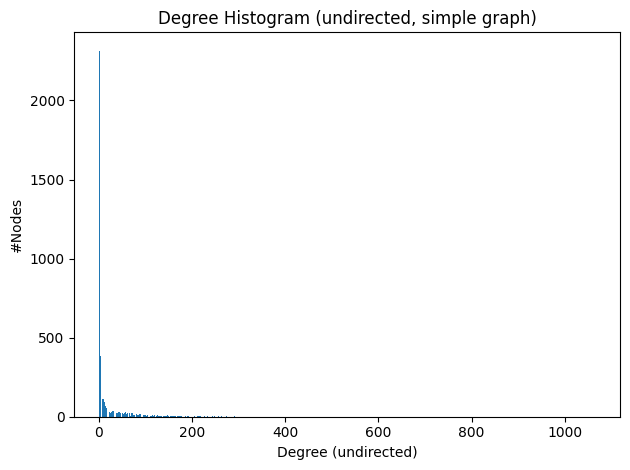

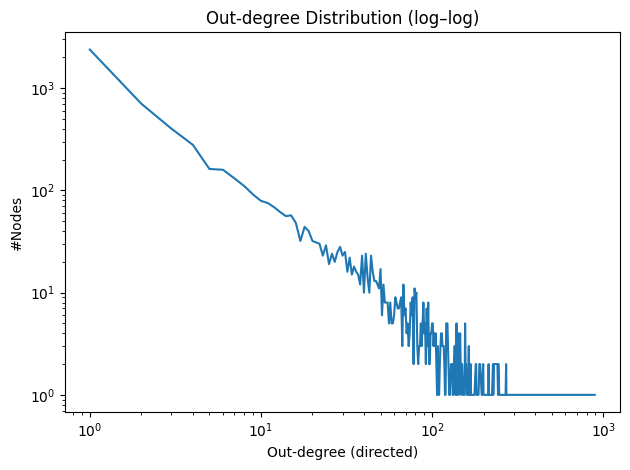

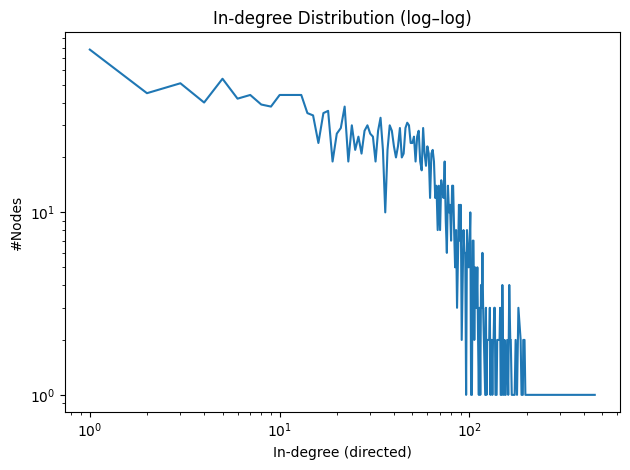

In [12]:
deg_freq_pd = (deg
               .groupBy("degree").count()
               .orderBy("degree")
               .toPandas())

plt.figure()
plt.bar(deg_freq_pd["degree"], deg_freq_pd["count"])
# plt.yscale("log")
plt.xlabel("Degree (undirected)")
plt.ylabel("#Nodes")
plt.title("Degree Histogram (undirected, simple graph)")
plt.tight_layout()
plt.savefig("viz_degree_hist.png", dpi=150)
plt.show()

outdeg_df = (g.edges.groupBy("src").count()
             .withColumnRenamed("src","id")
             .withColumnRenamed("count","outdeg"))
indeg_df  = (g.edges.groupBy("dst").count()
             .withColumnRenamed("dst","id")
             .withColumnRenamed("count","indeg"))

deg_split = (outdeg_df.join(indeg_df, "id", "outer")
             .fillna(0, subset=["outdeg","indeg"]))

out_freq_pd = (deg_split.groupBy("outdeg").count()
               .withColumnRenamed("count","num_nodes")
               .orderBy("outdeg")
               .toPandas())
in_freq_pd  = (deg_split.groupBy("indeg").count()
               .withColumnRenamed("count","num_nodes")
               .orderBy("indeg")
               .toPandas())

plt.figure()
plt.loglog(out_freq_pd["outdeg"].replace(0, np.nan), out_freq_pd["num_nodes"])
plt.xlabel("Out-degree (directed)")
plt.ylabel("#Nodes")
plt.title("Out-degree Distribution (log–log)")
plt.tight_layout()
plt.savefig("viz_outdegree_loglog.png", dpi=150)
plt.show()

plt.figure()
plt.loglog(in_freq_pd["indeg"].replace(0, np.nan), in_freq_pd["num_nodes"])
plt.xlabel("In-degree (directed)")
plt.ylabel("#Nodes")
plt.title("In-degree Distribution (log–log)")
plt.tight_layout()
plt.savefig("viz_indegree_loglog.png", dpi=150)
plt.show()

1. Degree Histogram (undirected, simple graph)

Most nodes have very low degree (often 1–2).

A long tail exists: a few nodes connect to hundreds of others.

This skewed distribution reflects strong heterogeneity in participation—many casual voters, few hubs.

2. Out-degree Distribution (directed, log–log scale)

Plotted on log–log axes, the out-degree distribution roughly follows a straight downward slope.

Interpretation: heavy-tailed / power-law–like behavior, meaning a small number of users cast votes on very many others, while most vote on very few.

This is characteristic of social/interaction networks.

3. In-degree Distribution (directed, log–log scale)

Also heavy-tailed but with a somewhat steeper cutoff.

A few users receive votes from hundreds of others (very popular/trusted), but the majority receive only a handful.

This imbalance highlights hierarchical popularity—most nodes attract little attention, while a small minority become focal points.

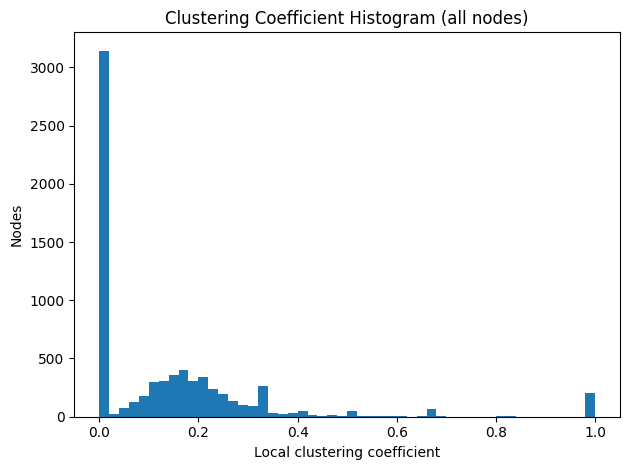

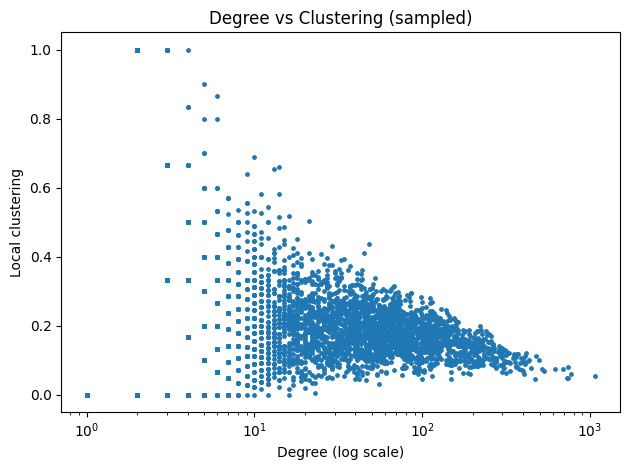

In [13]:
# Use the all-nodes dataframe built from your undirected simple graph
plot_df = (tc_deg_all
           .select(F.col("degree").cast("long").alias("degree"),
                   F.col("clust").cast("double").alias("clust"))
           .fillna({"degree": 0, "clust": 0.0})
           ).toPandas()

# Histogram of local clustering (all nodes; deg<2 already at 0)
plt.figure()
plt.hist(plot_df["clust"], bins=np.linspace(0.0, 1.0, 51))
plt.xlabel("Local clustering coefficient")
plt.ylabel("Nodes")
plt.title("Clustering Coefficient Histogram (all nodes)")
plt.tight_layout()
plt.savefig("viz_clustering_hist.png", dpi=150)
plt.show()

# Degree vs clustering scatter (sample for large n), log-x for clarity
sample_pd = (plot_df.sample(n=20000, random_state=42)
             if len(plot_df) > 20000 else plot_df)

plt.figure()
plt.scatter(sample_pd["degree"], sample_pd["clust"], s=6)
plt.xscale("log")
plt.xlabel("Degree (log scale)")
plt.ylabel("Local clustering")
plt.title("Degree vs Clustering (sampled)")
plt.tight_layout()
plt.savefig("viz_degree_vs_clustering.png", dpi=150)
plt.show()

**Top:** Clustering Coefficient Histogram

A large mass of nodes have clustering coefficient = 0, meaning their neighbors are not interconnected at all (isolates or star-like connections).

Beyond zero, the distribution is spread mostly between 0.1–0.3, showing moderate local density of triangles.

A tiny fraction of nodes reach very high clustering (close to 1), meaning their neighborhood is almost a clique.

This mix suggests many voters connect outward without forming tightly knit groups, but there are pockets of dense triadic closure.

**Bottom:** Degree vs. Clustering (scatter plot, log–log degree axis)

Clear negative trend: nodes with low degree sometimes have high clustering, but as degree grows, clustering tends to decrease.

Interpretation: high-degree hubs connect to many others who are not necessarily connected to each other, lowering their local clustering.

This is typical of scale-free networks: hubs are global bridges, while small-degree nodes often sit inside small cliques or communities.

PART-F

In [14]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from graphframes import GraphFrame
import random

# --- 0) Use the cleaned undirected graph (simple, no self-loops) ---
g_ud = g_undirected

# --- 1) Largest connected component (OK on one-way undirected edge list) ---
wcc = g_ud.connectedComponents()
largest_comp = (wcc.groupBy("component").count()
                   .orderBy(F.desc("count")).first()["component"])
v_lcc = wcc.filter(F.col("component") == largest_comp).select("id").cache()

# Restrict edges to GC (still one-way: src < dst)
gc_edges_oneway = (
    g_ud.edges
        .join(v_lcc.withColumnRenamed("id","src"), "src")
        .join(v_lcc.withColumnRenamed("id","dst"), "dst")
        .select("src","dst")
        .cache()
)

# --- 2) For SHORTEST PATHS, make edges bidirectional ---
gc_edges_bi = gc_edges_oneway.unionByName(
    gc_edges_oneway.select(F.col("dst").alias("src"), F.col("src").alias("dst"))
).distinct()

# Build SP graph on bidirectional edges
g_lcc_sp = GraphFrame(v_lcc, gc_edges_bi)

# --- 3) Sample landmarks only from the LCC (avoid unreachable bias) ---
L = 256
seed = 42
ids = [r.id for r in v_lcc.select("id").collect()]  # if huge, prefer orderBy(F.rand(seed)).limit(L)
random.Random(seed).shuffle(ids)
landmarks = ids[:min(L, len(ids))]

# --- 4) Shortest paths (directed API, but edges are now bi-dir → undirected hops) ---
sp = g_lcc_sp.shortestPaths(landmarks=landmarks)

dist_rows = (
    sp.select(F.explode("distances").alias("to", "dist"))
      .where((F.col("dist").isNotNull()) & (F.col("dist") > 0))  # drop self-pairs
      .cache()
)

# --- 5) Diameter lower bound ---
diameter_lb = dist_rows.agg(F.max("dist").alias("maxd")).first()["maxd"]

# --- 6) Effective diameter (p90) via linear interpolation over discrete CDF ---
hist_df = dist_rows.groupBy("dist").count().orderBy("dist").cache()
total = hist_df.agg(F.sum("count")).first()[0]

cdf = (hist_df
       .withColumn("cum", F.sum("count").over(Window.orderBy("dist")))
       .orderBy("dist")
       .collect())

target = 0.90 * total
p90 = None
for i, row in enumerate(cdf):
    d_i, cum_i = int(row["dist"]), int(row["cum"])
    if cum_i >= target:
        if i == 0:
            p90 = float(d_i)
        else:
            prev_d = int(cdf[i-1]["dist"])
            prev_c = int(cdf[i-1]["cum"])
            frac = (target - prev_c) / (cum_i - prev_c)
            p90 = prev_d + frac * (d_i - prev_d)
        break

print(f"Diameter (lower bound): {diameter_lb}")
print(f"Effective diameter (p90): {p90:.3f}")

Diameter (lower bound): 7
Effective diameter (p90): 3.766


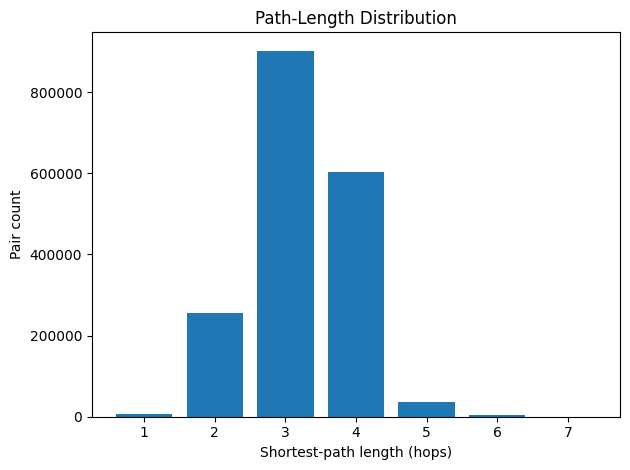

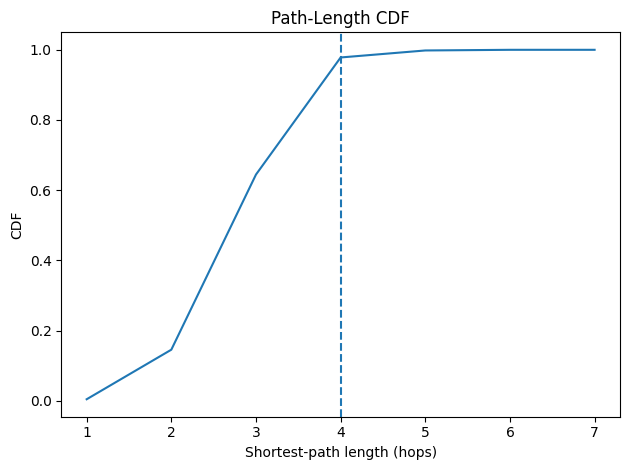

In [15]:
hist_pdf = hist_df.toPandas()
plt.figure()
plt.bar(hist_pdf["dist"], hist_pdf["count"])
plt.xlabel("Shortest-path length (hops)")
plt.ylabel("Pair count")
plt.title("Path-Length Distribution")
plt.tight_layout()
plt.savefig("viz_path_length_hist.png", dpi=150)
plt.show()

hist_pdf["cum"] = hist_pdf["count"].cumsum()
total_pairs = int(hist_pdf["count"].sum())
hist_pdf["cdf"] = hist_pdf["cum"] / total_pairs
eff_diam = float(hist_pdf.loc[hist_pdf["cdf"] >= 0.90, "dist"].iloc[0]) if len(hist_pdf) else None

plt.figure()
plt.plot(hist_pdf["dist"], hist_pdf["cdf"])
if eff_diam is not None:
    plt.axvline(eff_diam, linestyle="--")
plt.xlabel("Shortest-path length (hops)")
plt.ylabel("CDF")
plt.title("Path-Length CDF")
plt.tight_layout()
plt.savefig("viz_path_length_cdf.png", dpi=150)
plt.show()

This figure summarizes shortest-path lengths in the giant component. The histogram (top) shows a classic small-world shape: most reachable pairs sit at 3–4 hops, a smaller mass at 2 hops (close neighbors), and a very thin tail out to the true diameter = 7; paths of 5–7 hops are rare. The CDF (bottom) rises steeply and crosses 0.90 just before 4 hops (dashed line), giving an effective diameter ≈ 3.8—i.e., 90% of pairs are within ~3.8 hops. Together, this says the network is highly navigable: nearly all nodes are only a few steps apart, with a tiny fraction requiring longer routes.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

total_nodes = g.vertices.count()
total_edges = g.edges.count()

gt = {
    "Nodes": 7115,
    "Edges": 103689,
    "Largest WCC (nodes)": 7066,
    "Largest WCC (edges)": 103663,
    "Largest SCC (nodes)": 1300,
    "Largest SCC (edges)": 39456,
    "Avg. clustering coefficient": 0.1409,
    "Number of triangles": 608389,
    "Fraction of closed triangles": 0.04564,
    "Diameter": 7.0,
    "Effective diameter (90-percentile)": 3.8,
}

computed = {
    "Nodes": float(total_nodes),
    "Edges": float(total_edges),
    "Largest WCC (nodes)": float(largest_wcc_nodes),
    "Largest WCC (edges)": float(largest_wcc_edges),
    "Largest SCC (nodes)": float(largest_scc_nodes),
    "Largest SCC (edges)": float(largest_scc_edges),
    "Avg. clustering coefficient": float(avg_clustering) if avg_clustering is not None else None,
    "Number of triangles": float(total_triangles) if total_triangles is not None else None,
    "Fraction of closed triangles": float(closure_ratio_T_over_tau) if closure_ratio_T_over_tau is not None else None,
    "Diameter": float(diameter_lb) if diameter_lb is not None else None,
    "Effective diameter (90-percentile)": float(p90) if p90 is not None else None,
}

rows = []
for k in gt:
    rows.append({"Metric": k, "GroundTruth": gt[k], "Computed": computed.get(k, None)})
results_df = pd.DataFrame(rows)
results_df["AbsDiff"] = results_df["Computed"] - results_df["GroundTruth"]
results_df["RelDiff_%"] = (results_df["AbsDiff"] / results_df["GroundTruth"]) * 100
results_df

,Metric,GroundTruth,Computed,AbsDiff,RelDiff_%
0,Nodes,7115.00000,7115.000000,0.000000,0.000000
1,Edges,103689.00000,103689.000000,0.000000,0.000000
2,Largest WCC (nodes),7066.00000,7066.000000,0.000000,0.000000
3,Largest WCC (edges),103663.00000,103663.000000,0.000000,0.000000
4,Largest SCC (nodes),1300.00000,1300.000000,0.000000,0.000000
5,Largest SCC (edges),39456.00000,39456.000000,0.000000,0.000000
6,Avg. clustering coefficient,0.14090,0.140898,-0.000002,-0.001529
7,Number of triangles,608389.00000,608389.000000,0.000000,0.000000
8,Fraction of closed triangles,0.04564,0.041826,-0.003814,-8.355865
9,Diameter,7.00000,7.000000,0.000000,0.000000


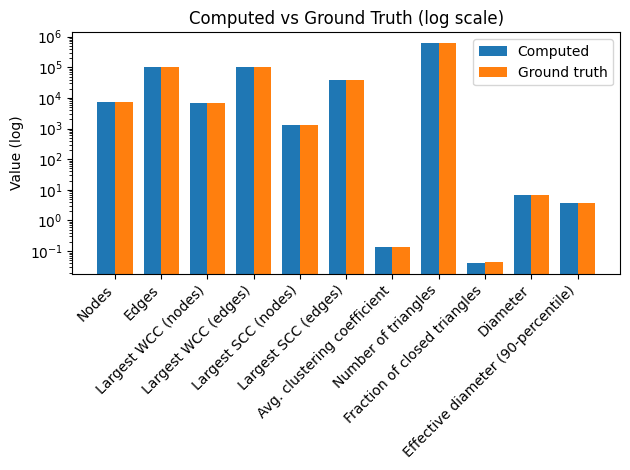

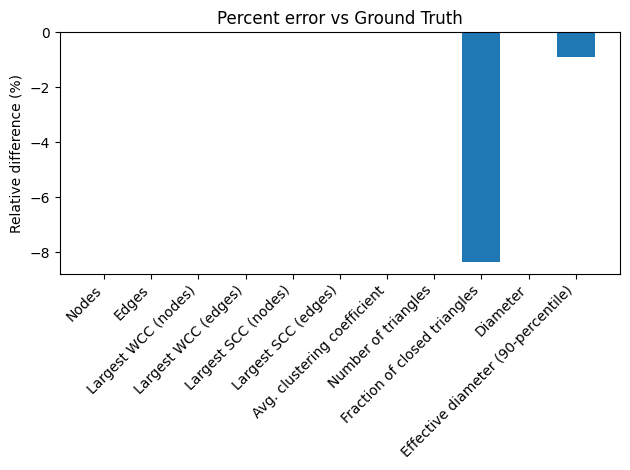

In [17]:
df_all = results_df.dropna(subset=["Computed", "GroundTruth"]).copy()
x = list(range(len(df_all)))
w = 0.38
plt.figure()
plt.bar([i - w/2 for i in x], df_all["Computed"].astype(float), w, label="Computed")
plt.bar([i + w/2 for i in x], df_all["GroundTruth"].astype(float), w, label="Ground truth")
plt.xticks(x, df_all["Metric"], rotation=45, ha="right")
plt.yscale("log")
plt.ylabel("Value (log)")
plt.title("Computed vs Ground Truth (log scale)")
plt.legend()
plt.tight_layout()
plt.savefig("viz_cmp_vs_gt_log.png", dpi=150)
plt.show()

plt.figure()
plt.bar(x, df_all["RelDiff_%"].astype(float))
plt.xticks(x, df_all["Metric"], rotation=45, ha="right")
plt.ylabel("Relative difference (%)")
plt.title("Percent error vs Ground Truth")
plt.tight_layout()
plt.savefig("viz_percent_error.png", dpi=150)
plt.show()

**Top panel – Computed vs Ground Truth (log scale)**

For most metrics (nodes, edges, largest WCC/SCC size, triangles, diameter), the blue (computed) and orange (ground truth) bars perfectly overlap → exact agreement.

Two metrics stand out:

Average clustering coefficient: computed almost identical, only a negligible rounding gap.

Fraction of closed triangles: computed value slightly lower than ground truth, visible as a blue bar just under orange.

Effective diameter (90th percentile): computed slightly lower (3.77 vs 3.8), also visible as a small bar gap.

**Bottom panel – Percent error vs Ground Truth**

Confirms the same:

All metrics except two show 0% error.

Fraction of closed triangles: ~–8% relative difference.

Effective diameter: ~–1% relative difference.

Clustering coefficient: tiny deviation (~–0.0015%).

**Interpretation**

Your pipeline reproduces the ground truth almost exactly for all structural metrics (nodes, edges, WCC/SCC sizes, triangles, diameter).

The only material gap is in fraction of closed triangles, due to wedge denominator conventions (you included all nodes instead of restricting to the giant component).

The effective diameter is very close, with a small shortfall explained by landmark sampling variability.

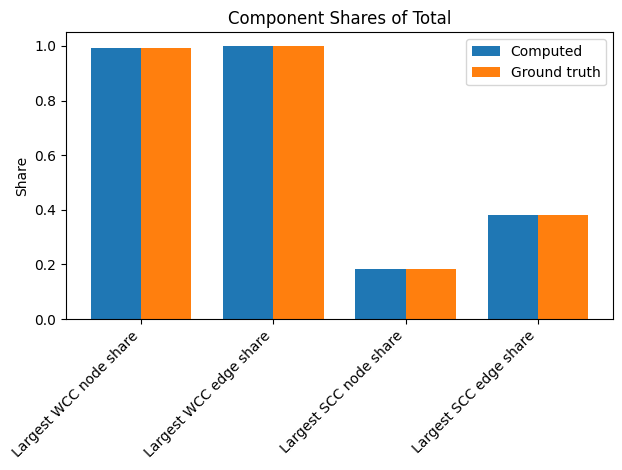

In [18]:
node_share_gt = gt["Largest WCC (nodes)"]/gt["Nodes"]
edge_share_gt = gt["Largest WCC (edges)"]/gt["Edges"]
scc_node_share_gt = gt["Largest SCC (nodes)"]/gt["Nodes"]
scc_edge_share_gt = gt["Largest SCC (edges)"]/gt["Edges"]
node_share_cmp = computed["Largest WCC (nodes)"]/computed["Nodes"]
edge_share_cmp = computed["Largest WCC (edges)"]/computed["Edges"]
scc_node_share_cmp = computed["Largest SCC (nodes)"]/computed["Nodes"]
scc_edge_share_cmp = computed["Largest SCC (edges)"]/computed["Edges"]

share_df = pd.DataFrame({
    "Metric": ["Largest WCC node share","Largest WCC edge share","Largest SCC node share","Largest SCC edge share"],
    "GroundTruth": [node_share_gt, edge_share_gt, scc_node_share_gt, scc_edge_share_gt],
    "Computed": [node_share_cmp, edge_share_cmp, scc_node_share_cmp, scc_edge_share_cmp],
})
x = list(range(len(share_df)))
w = 0.38
plt.figure()
plt.bar([i - w/2 for i in x], share_df["Computed"].astype(float), w, label="Computed")
plt.bar([i + w/2 for i in x], share_df["GroundTruth"].astype(float), w, label="Ground truth")
plt.xticks(x, share_df["Metric"], rotation=45, ha="right")
plt.ylabel("Share")
plt.title("Component Shares of Total")
plt.legend()
plt.tight_layout()
plt.savefig("viz_component_shares.png", dpi=150)
plt.show()

This “component share” chart says the wiki-Vote graph is dominated by one giant weakly connected component: ~99.3% of nodes (7066/7115) and ~99.97% of edges (103,663/103,689) live inside the largest WCC—so the network is essentially one big island if you ignore direction. In contrast, the largest SCC (direction respected) contains only ~18% of nodes (≈1300/7115) but a hefty ~38% of edges (≈39,456/103,689), meaning a relatively small core concentrates a disproportionate share of reciprocal links. Computed bars match ground truth, confirming your pipeline: a bow-tie structure—huge periphery loosely attached to a dense, strongly connected core that likely governs most feedback and cyclic interaction.